# Up and running with PANDA and netZooPy

### Author:
Daniel Morgan*.

*Channing division of network medicine, Brigham's and Women hospital and Harvard Medical School, Boston, MA.

## Introduction
Regulatory network reconstruction is a fundamental problem in computational biology. There are significant limitations to such reconstruction using individual datasets, and increasingly people attempt to construct networks using multiple, independent datasets obtained from complementary sources, but methods for this integration are lacking. We developed PANDA (Passing Attributes between Networks for Data Assimilation), a message-passing model using multiple sources of information to predict regulatory relationships, and used it to integrate protein-protein interaction, gene expression, and sequence motif data to reconstruct genome-wide, condition-specific regulatory networks in yeast as a model. The resulting networks were not only more accurate than those produced using individual data sets and other existing methods, but they also captured information regarding specific biological mechanisms and pathways that were missed using other methodologies. PANDA is scalable to higher eukaryotes, applicable to specific tissue or cell type data and conceptually generalizable to include a variety of regulatory, interaction, expression, and other genome-scale data.

PANDA starts with a prior network of putative regulatory interactions (center network in the image below), a prior network of protein-protein interactions between transcription factors, and target gene expression data, which is converted into a co-expression network.

<img src="../../img/panda.png" style="width: 200px;">  

A message passing framework is used to find agreement between the three input networks. First, the responsibility (R) is calculated: 

<img src="../../img/responsibility.png" style="width: 200px;">  

as well as the availability (A): 

<img src="../../img/availability.png" style="width: 200px;">  

The prior gene regulatory network W is then updated using the responsibility and availability:  

<img src="../../img/combine.png" style="width: 300px;">  

Next, the protein cooperativity and gene co-regulatory networks are updated::

<img src="../../img/cooperativity.png" style="width: 300px;">  
<img src="../../img/co-regulatory.png" style="width: 300px;"> 

Self-interactions in P and C are also updated to satisfy convergence:  

<img src="../../img/p.png" style="width: 300px;">  
<img src="../../img/c.png" style="width: 300px;">  

, which is evaluated using a hamming distance:

<img src="../../img/hamming.png" style="width: 300px;">  

In [19]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://journals.plos.org/plosone/article/figure/image?size=large&id=info:doi/10.1371/journal.pone.0064832.g001", width=500, height=500)

## 1. Installation and Setup

In [20]:
%%bash
cd ~
# git clone https://github.com/netZoo/netZooPy.git
cd netZooPy
pip3 install -e .

Obtaining file:///Users/redmo/netZooPy
  Found existing installation: netZooPy 0.1.1
    Uninstalling netZooPy-0.1.1:
      Successfully uninstalled netZooPy-0.1.1
  Running setup.py develop for netZooPy


or with conda

In [21]:
# source activate myenv
# conda install git pip
# pip install git+git://github.com/netZoo/netZooPy.git

In [22]:
import os
# os.getcwd()
# os.chdir("~/")
os.getcwd()

'/Users/redmo'

In [23]:
from netZooPy.panda.panda import Panda
import pandas as pd
import matplotlib.pyplot as plt

## 2. Parameter Setting & Exploring the Data

First, we start by setting the path to the 1) motif prior network, 2) the gene expression data, and 3) the ppi network data.
The motif prior network is typically a TF-by-gene binary matrix where 1 indicates the presence of sequence (motif) of a TF in the gene regulatory region and 0 otherwise.
Gene expression data is typically a gene-by-sample matrix containing expression data.
PPI network is a TF-by-TF binary matrix, where 1 indicates a physical interaction between two TFs and 0 otherwise.
If two TFs are likely to binding, they are likely to form regulatory complexes for the same genes.

In [24]:
expression_data='netZooPy/tests/ToyData/ToyExpressionData.txt'
motif_data='netZooPy/tests/ToyData/ToyMotifData.txt'
ppi_data='netZooPy/tests/ToyData/ToyPPIData.txt'
panda_output='netZooPy/tests/panda/output_panda.txt'

There are 1000 genes and 51 samples in our toy data. This is your novel input. The remaining files are known interaction lists.

In [25]:
motif_data=pd.read_csv(motif_data,sep="\t",header=None)
motif_data[0].unique().size

87

In [26]:
motif_data[1].unique().size

913

Since the first column is TF, you thus have 87 TF and 913 genes are returned from the second column, with their interaction weights in the third column (motif_data[2]). Now lets check out the ppi data, another interaction list with three columns, with 238 interactions between the TF.

In [27]:
ppi_data=pd.read_csv(ppi_data,sep="\t",header=None)
ppi_data.shape

(238, 3)

## 3. Calling PANDA

One can chose to run in terminal simply by pointing to the input files

In [28]:
# %%bash
# cd netZooPy
# pip3 install -e .
# python netZooPy/panda/run_panda.py -e netZooPy/tests/ToyData/ToyExpressionData.txt -m netZooPy/tests/ToyData/ToyMotifData.txt -p netZooPy/tests/ToyData/ToyPPIData.txt -f True -o test_panda.txt

Alternatively one can continue running in Jupyter, using all data sources:

In [40]:
expression_data='netZooPy/tests/ToyData/ToyExpressionData.txt'
motif_data='netZooPy/tests/ToyData/ToyMotifData.txt'
ppi_data='netZooPy/tests/ToyData/ToyPPIData.txt'
panda_obj = Panda(expression_data, motif_data, ppi_data, save_tmp=True,save_memory = False, remove_missing=False, keep_expression_matrix = False)
panda_obj.save_panda_results(panda_output)

Loading motif data ...
Unique TFs: 87
  Elapsed time: 0.01 sec.
Loading expression data ...
Expression matrix: (1000, 50)
  Elapsed time: 0.02 sec.
Loading PPI data ...
Number of PPIs: 238
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.01 sec.
Creating motif network ...
  Elapsed time: 0.01 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
Normalizing networks ...
  Elapsed time: 0.03 sec.
Saving expression matrix and normalized networks ...
  Elapsed time: 0.00 sec.
Running PANDA algorithm ...


/Users/redmo/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: divide by zero encountered in true_divide
  return (a - mns) / sstd


Saving PANDA network to netZooPy/tests/panda/output_panda.txt ...
  Elapsed time: 0.22 sec.


In [30]:
import sys
sys.getsizeof(panda_obj)

64

/Users/redmo/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/redmo/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/redmo/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


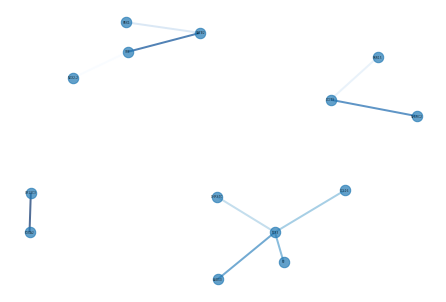

In [31]:
panda_obj.top_network_plot(top=10)

using only the motif prior

In [32]:
expression_data=None
motif_data='netZooPy/tests/ToyData/ToyMotifData.txt'
ppi_data=None
panda_obj = Panda(expression_data,  motif_data, ppi_data,remove_missing=True)
panda_obj.save_panda_results(panda_output)

Loading motif data ...
Unique TFs: 87
  Elapsed time: 0.02 sec.
No Expression data given: correlation matrix will be an identity matrix of size 913
No PPI data given: ppi matrix will be an identity matrix of size 87
Remove motif not in expression data:
   0 rows removed from the initial 14597
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.01 sec.
Normalizing networks ...
  Elapsed time: 0.03 sec.
Saving expression matrix and normalized networks ...
  Elapsed time: 0.00 sec.
Running PANDA algorithm ...
Saving PANDA network to netZooPy/tests/panda/output_panda.txt ...
  Elapsed time: 0.22 sec.


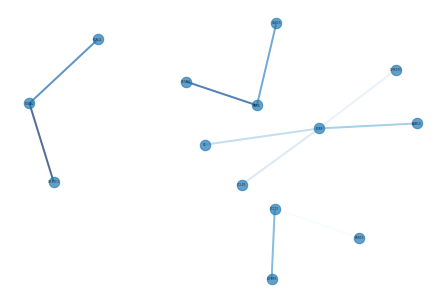

In [33]:
panda_obj.top_network_plot(top=10)

without the expression matrix

In [34]:
expression_data=None
motif_data='netZooPy/tests/ToyData/ToyMotifData.txt'
ppi_data='netZooPy/tests/ToyData/ToyPPIData.txt'
panda_obj = Panda(expression_data,  motif_data, ppi_data,remove_missing=True)
panda_obj.save_panda_results(panda_output)

Loading motif data ...
Unique TFs: 87
  Elapsed time: 0.02 sec.
No Expression data given: correlation matrix will be an identity matrix of size 913
Loading PPI data ...
Number of PPIs: 238
  Elapsed time: 0.00 sec.
Remove motif not in expression data:
   0 rows removed from the initial 14597
Remove ppi not in motif:
   0 rows removed from the initial 238
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.01 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
Normalizing networks ...
  Elapsed time: 0.03 sec.
Saving expression matrix and normalized networks ...
  Elapsed time: 0.00 sec.
Running PANDA algorithm ...
Saving PANDA network to netZooPy/tests/panda/output_panda.txt ...
  Elapsed time: 0.21 sec.


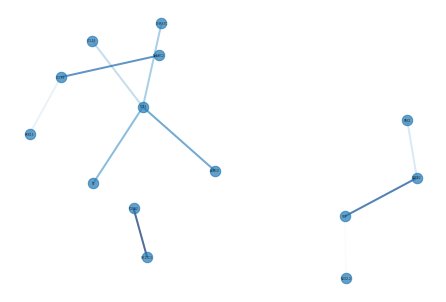

In [35]:
panda_obj.top_network_plot(top=10)

and without using a motif prior

In [36]:
expression_data='netZooPy/tests/ToyData/ToyExpressionData.txt'
motif_data=None
ppi_data='netZooPy/tests/ToyData/ToyPPIData.txt'
panda_obj = Panda(expression_data, motif_data, ppi_data)
panda_obj.save_panda_results(panda_output)

Loading expression data ...
Expression matrix: (1000, 50)
  Elapsed time: 0.02 sec.
Loading PPI data ...
Number of PPIs: 238
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.01 sec.
Returning the correlation matrix of expression data in <Panda_obj>.correlation_matrix
Saving PANDA network to netZooPy/tests/panda/output_panda.txt ...
  Elapsed time: 1.99 sec.


and saving memory by deleting intermediary files

In [38]:
expression_data='netZooPy/tests/ToyData/ToyExpressionData.txt'
motif_data='netZooPy/tests/ToyData/ToyMotifData.txt'
ppi_data='netZooPy/tests/ToyData/ToyPPIData.txt'
panda_obj = Panda(expression_data, motif_data, ppi_data, save_memory=True)
panda_obj.save_panda_results(panda_output)

Loading motif data ...
Unique TFs: 87
  Elapsed time: 0.02 sec.
Loading expression data ...
Expression matrix: (1000, 50)
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 238
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.01 sec.
Creating motif network ...
  Elapsed time: 0.01 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
Normalizing networks ...
  Elapsed time: 0.03 sec.
Clearing motif and ppi data, unique tfs, and gene names for speed
Saving expression matrix and normalized networks ...
  Elapsed time: 0.01 sec.
Running PANDA algorithm ...
Saving PANDA network to netZooPy/tests/panda/output_panda.txt ...
  Elapsed time: 0.08 sec.


Basic follow up analysis is also possible, such as degree calculation per gene

In [46]:
panda_obj.return_panda_indegree()

,force
gene,
41157,1.139713
AACSL,-5.090725
AAK1,-10.923515
ABCA17P,-8.919393
ABCB8,9.091765
...,...
ZNF826,-7.009150
ZNF845,-7.942670
ZNF878,-11.919082


panda_obj.save_panda_results()

## 4. References
Glass K, Huttenhower C, Quackenbush J, Yuan GC. Passing Messages Between Biological Networks to Refine Predicted Interactions, PLoS One, 2013 May 31;8(5):e64832